# Backpropagation Lab
## February 2022
### Overview: Manual implementation of a backpropagation algorithm

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
import pandas as pd

## 1. (40%) Correctly implement and submit your own code for the backpropagation algorithm. 

## Code requirements 
- Ability to create a network structure with at least one hidden layer and an arbitrary number of nodes.
- Random weight initialization with small random weights with mean of 0 and a variance of 1.
- Use Stochastic/On-line training updates: Iterate and update weights after each training instance (i.e., do not attempt batch updates)
- Implement a validation set based stopping criterion.
- Shuffle training set at each epoch.
- Option to include a momentum term

Use your Backpropagation algorithm to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your script on the Evaluation data with the same parameters, and print your final weights.

In [2]:
class MLPNode():
    def __init__(self,weights,lr,name,momentum=0,end_node=False,bias_node=False,input_node=False):
        """
        Initialize a node class with the following attributes
        """
        #weights are weights surpise, Inputs will hold all forward incoming data, backputs will hold all backward incoming
        #data
        self.weights = np.array(weights)
        self.Inputs = []
        self.backputs = []
        
        #booleans about type of node
        self.end_node = end_node
        self.bias_node = bias_node
        self.input_node = input_node
        
        #learning rate and momentum
        self.lr = lr
        self.momentum = momentum
        
        #clicked is an index tracker
        self.clicked = 0
        
        #you can pass in a name for the little guy
        self.name=name
        
        #initialize a list of deltas that will be used only when momentum is nonzero
        if weights is not None:
            self.deltas = np.array([0.]*len(weights))
    
    def set_manual(self,manual):
        """Save the manually input input (for input_node only)"""
        self.manual = manual
        
    def set_target(self,target):
        """Save the target value if node is endnode"""
        self.target = target
    
    def process(self):
        """Run the net of the inputs through sigmoid (if not input node or bias node)"""
        if self.input_node:
            self.z = self.manual
            
        elif self.bias_node:
            self.z = 1. 
            
        else:
            net = sum(self.Inputs)
            self.z = 1. / (1. + np.exp(-net))
        
    def send_output(self):
        """Return the output of the sigmoid times the weight"""
        self.process()
        return self.z*self.weights[self.clicked]
    
    def receive_input(self,Input):
        """Store all inputs from incoming connected nodes"""
        self.Inputs.append(Input)
    
    def __rshift__(self,other):
        """Shorthand for sending information forward between nodes"""
        other.receive_input(self.send_output())
        self.clicked += 1
    
    def recieve_backputs(self,other):
        """Store all deltas and respective weights backpropped from subsequent nodes"""
        self.backputs.insert(0,[other.delta,self.weights[self.clicked-1]])
        self.clicked -= 1
        
    def __lshift__(self,other):
        """Shorthand for sending information backward between nodes"""
        self.recieve_backputs(other.calc_error())
    
    def calc_error(self):
        """Calculate the error delta"""
        #if endnode, calc error delta without backputs
        self.process()
        if self.end_node:
            self.delta = (self.target - self.z)*self.z*(1.-self.z)
            
        #if not endnode, must use backput deltas and weights to calc error delta
        else:
            Sum = np.dot(np.array(self.backputs).T[0],np.array(self.backputs).T[1])
            self.delta = Sum*self.z*(1-self.z)
            
        return self
    
    def update_weights(self):
        """Update the weights"""
        #use the backputs to calculate how the weights should change
        backy = np.array([self.backputs]).T[0]
        delta = (self.lr * backy * self.z).flatten() + (self.momentum * self.deltas).flatten()
        self.weights += delta
        self.deltas = delta
    
    def reset(self):
        """Reset the input and backput lists"""
        self.Inputs = []
        self.backputs = []
        
    def __str__(self):
        return self.name

In [3]:
class MLP(BaseEstimator,ClassifierMixin):

    def __init__(self,lr=.1, momentum=0, shuffle=True,hidden_layer_widths=None,determ=True,validate=False):
        """ Initialize class with chosen hyperparameters.

        Args:
            lr (float): A learning rate / step size.
            shuffle(boolean): Whether to shuffle the training data each epoch. DO NOT SHUFFLE for evaluation / debug datasets.
            momentum(float): The momentum coefficent 
        Optional Args (Args we think will make your life easier):
            hidden_layer_widths (list(int)): A list of integers which defines the width of each hidden layer. if hidden layer is none do twice as many hidden nodes as input nodes. (and then one more for the bias node)
            For example: input width 1, then hidden layer will be 3 nodes
        Example:
            mlp = MLP(lr=.2,momentum=.5,shuffle=False,hidden_layer_widths = [3,3]),  <--- this will create a model with two hidden layers, both 3 nodes wide
        """
        self.hidden_layer_widths = hidden_layer_widths
        self.lr = lr
        self.momentum = momentum
        self.shuffle = shuffle
        self.determ = determ
        self.validate = validate
        
    def make_nodes(self,X,y, initial_weights):
        """Create list of nodes"""
        #initially populate Nodes list with Nones
        Nodes = []
        for number in self.nodeCount:
            Nodes.append([None]*(number+1))    #plus 1 is for the bias node
        if len(y.shape)==1:                    #end nodes:
            Nodes.append([None])
        else:
            Nodes.append([None]*len(y[0]))
        
        #NOW CREATING WEIGHTS
        if initial_weights is None:
            self.weights = self.initialize_weights(Nodes.copy())
        else: 
            if len(np.array([initial_weights]).shape) != 1:
                raise ValueError("to initialize weight, must put in scalar, which will be uniformly applied to all weights")
            self.weights = self.initialize_weights(Nodes.copy(),initial_weights)
        
        #Now populating lists with nodes
        for i in range(len(Nodes)-1):
            for j in range(len(Nodes[i])-1):
                #if input node
                if i == 0:
                    Nodes[i][j] = MLPNode( self.weights[i][j],self.lr,'['+str(i)+']['+str(j)+']',self.momentum,input_node=True  )
                    
                #otherwise hidden layer node (default)
                else:
                    Nodes[i][j] = MLPNode( self.weights[i][j],self.lr,'['+str(i)+']['+str(j)+']',self.momentum,  )
            #adding bias node
            Nodes[i][-1] = MLPNode(self.weights[i][-1],self.lr,'['+str(i)+']['+str(len(Nodes[i])-1)+'](bias)',self.momentum,bias_node=True  )
            
        #adding end nodes
        for j in range(len(Nodes[-1])):
            Nodes[-1][j]=MLPNode(None,self.lr,'['+str(len(Nodes)-1)+']['+str(j)+'](end)',end_node=True)
            
        return Nodes
    
    def run_forward(self,Nodes,pred=False):
        """Run the forward propagation algorithm"""
        #now feed forward from input nodes, to hidden layer 1,..., to hidden layer n, to output layer
        for i in range(len(Nodes)-2):
            for j in range(len(Nodes[i])):
                for m in range(len(Nodes[i+1])-1):
                    Nodes[i][j] >> Nodes[i+1][m]
                if pred: self.Nodes[i][j].clicked = 0
                    
        for j in range(len(Nodes[-2])):
            
            for m in range(len(Nodes[-1])):
                Nodes[-2][j] >> Nodes[-1][m]
                
        #if predicting, the index tracker must be reset
        if pred: 
            for j in range(len(self.Nodes[-2])):
                self.Nodes[-2][j].clicked = 0
        
        #print('\n')
        return Nodes
        
    def run_backward(self,Nodes):
        """Run the back propagation algorithm"""
        #now backprop the error THIS MUST BE DONE IN THE EXACT OPPOSITE ORDER OF THE FEED FORWARD
        for j in reversed(range(len(Nodes[-2]))):
            for m in reversed(range(len(Nodes[-1]))):
                Nodes[-2][j] << Nodes[-1][m]
        
        for i in reversed(range(len(Nodes)-2)):
            for j in reversed(range(len(Nodes[i]))):
                for m in reversed(range(len(Nodes[i+1])-1)):
                    Nodes[i][j] << Nodes[i+1][m]
        return Nodes
    
    def fit(self, x, Y, initial_weights=None,Cap=np.inf,vPercent=0.15,threshold=0.1,dontFit=False):
        """ Fit the data; run the algorithm and adjust the weights to find a good solution

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Optional Args (Args we think will make your life easier):
            initial_weights (array-like): allows the user to provide initial weights
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)

        """
        print('next fit starting')
        X = x.copy()
        y = Y.copy()
        #if a validation set is to be used, set it apart from the rest of the data
        if self.validate:
            #shuffle the data for good measure
            X,y = self._shuffle_data(X,y)
            
            #init lists to hold scores, and init counters to keep track of MSE convergence, divergence
            self.MSEs = [100.]
            self.vScores = []
            self.components = np.array([1.]*len(y[0]))
            valid_count = 0
            bad_count = 0
            
            #get vPercent% of the data
            portion = round(vPercent*len(X))
            validX = X[:portion]
            validy = y[:portion]
            
            #what will be used to train on
            X = x[portion:]
            y = Y[portion:]
            
        #creating a list to hold all the nodes; starting with a list of the number of nodes for each layer
        if self.hidden_layer_widths is None:
            self.hidden_layer_widths = [2*len(X)]
        self.nodeCount = [len(X[0])]+self.hidden_layer_widths
        
        #creating nodes
        Nodes = self.make_nodes(X,y,initial_weights)
        self.Nodes = Nodes
        if self.validate:
            self.vScores.append(self.score(validX,validy))
        
        #if want a baseline accuracy without ever fitting, just return
        if dontFit: return self
        
        self.itrs = 1
        while self.itrs <= Cap:
            #print(self.itrs)
            #for every line of input, run
            for i, inpLine in enumerate(X):

                #set the values for the input nodes
                for j, inp in enumerate(inpLine):
                    Nodes[0][j].set_manual(inp)
                
                #set the values for the target nodes
                for j, target in enumerate(y[i]):
                    Nodes[-1][j].set_target(target)
                
                #forward propagate, then back propagate
                Nodes = self.run_forward(Nodes)
                Nodes = self.run_backward(Nodes)
        
                #updating weights and resetting nodes
                for sub in Nodes[:-1]:
                    for node in sub:
                        node.update_weights()
                        node.reset()
                for node in Nodes[-1]:
                    node.reset()
            
            #saving nodes as attributes
            self.Nodes = Nodes
            
            #if using validation set, checking if MSEs are within 0.375 distance from each other
            if self.validate:
                #mse, accuracy score, and component-wise scores all on validation sets
                mse = self.score(validX,validy,MSE=True)
                vScore = self.score(validX,validy)
                self.components = np.vstack((self.components,self.score(validX,validy,components=True)))
                self.vScores.append(vScore)
                
                #checking if mse values are converging or increasing
                if abs(mse - self.MSEs[self.itrs-1]) <= threshold:
                    valid_count += 1
                    if mse > self.MSEs[self.itrs-1]: bad_count += 1
                    else: bad_count = 0
                else: valid_count = 0
                self.MSEs.append(mse)
            
            #incrementing iter counter and printing if have reached cap on iters
            self.itrs += 1
            if self.itrs > Cap: print('cap reached, breaking\n')
                
            #if using validation set, check if MSEs have converged ten times in a row; if so, break
            if self.validate:
                if valid_count >= 10:
                    if not self.determ:
                        print('MSE converging, breaking\n')
                        break
                elif bad_count == 5:
                    if not self.determ:
                        print('MSE worsening, breaking\n')
                        break
            #shuffle            
            if self.shuffle:
                X,y = self._shuffle_data(X,y)
        
        #resetting the nodes' clicked attribute for indexing purposes in the predict function
        for sub in Nodes:
            for node in sub:
                node.clicked = 0
        
        #finally saving as attribute again
        self.Nodes = Nodes
        
        #if validation set being used, cut out first data point which was just noise to fill the space
        if self.validate: 
            self.MSEs = self.MSEs[1:]
            self.components = self.components[1:]
        return self

    def initialize_weights(self,Nodes,value=None):
        """ Initialize weights for backprop.
        Uses the Nodes list construction to fill each spot with a list of weights for the respective node connecting
        it to all the nodes (except the bias) on the next layer
        """
        if value is None:
            #for all but the second to last row
            for i in range(len(Nodes)-2):
                #make lists of random normal weights the size of the next layer minus 1
                nextLen = len(Nodes[i+1])-1
                for j in range(len(Nodes[i])):
                    Nodes[i][j] = np.random.normal(size=nextLen)
                    
            #for second to last layer, need exactly number of weights as there are output nodes (no bias to avoid this time)
            for j in range(len(Nodes[-2])):
                Nodes[-2][j] = np.random.normal(size=len(Nodes[-1]))
            
            #don't need weight(s) for final node (the output node)
            
        else:
            #for all but the second to last row
            for i in range(len(Nodes)-2):
                #make lists of random normal weights the size of the next layer minus 1
                nextLen = len(Nodes[i+1])-1
                for j in range(len(Nodes[i])):
                    Nodes[i][j] = [value]*nextLen
                    
            #for second to last layer, need exactly number of weights as there are output nodes (no bias to avoid this time)
            for j in range(len(Nodes[-2])):
                Nodes[-2][j] = [value]*len(Nodes[-1])
            
            #don't need weight(s) for final node (the output node)
        
        return Nodes

    def predict(self, X):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        #initializing list of predictions
        predsz = []
        
        #for all the input...
        for i, inpLine in enumerate(X):
            #first reset the nodes' inputs and backputs
            for sub in self.Nodes:
                for node in sub:
                    node.reset()
            
            #set the values for the input nodes
            for j, inp in enumerate(inpLine):
                self.Nodes[0][j].set_manual(inp)
            
            #prop forward
            self.Nodes = self.run_forward(self.Nodes,pred=True)
            
            #record z values
            for node in self.Nodes[-1]: node.process()
            predsz.append([node.z for node in self.Nodes[-1]])
        
        #make into array
        predsz = np.array(predsz)
        
        #if targets are 1d, then just compare with the average
        preds = predsz.copy()
        if preds.shape[1] == 1:
            avg = np.mean(preds)
            
            #if less than average, change into 1, else 0 (yes, this is how it works for this one)
            for i in range(len(preds)):
                if preds[i][0] <= avg: preds[i][0] = 1
                else: preds[i][0] = 0
        
        #if targets are not 1d...
        else:
            for i in range(len(preds)):
                #find index of max entry, set everything else to zero, set maxind to you
                maxind = np.argmax(preds[i])
                preds[i] = np.zeros(len(preds[i]))
                preds[i][maxind] = 1
        
        #save as attributes and return
        self.predsz = predsz
        self.preds = preds
        return self.predsz, self.preds
    
    def score(self, X, y,MSE=False,components=False):
        """ Return accuracy of model on a given dataset. Must implement own score function.

        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets

        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        #getting predictions
        predsz, preds = self.predict(X)
        
        #initializing counters 
        total = 0
        number = 0
        
        #comparing all prediction value with corresponding target value
        if not MSE and not components:
            for i, T in enumerate(preds):
                if np.allclose(T,y[i]): 
                    total +=1
                number +=1
                
        elif MSE and not components:
            mse = ( (predsz - y)**2  ).mean()
            return mse
        
        else: #if components
            #returning the score of each component individually
            L = y - preds
            L = np.where(L<0,0,L)
            
            score = 1 - (np.sum(L,axis=0)/np.sum(y,axis=0))
            
            #score[i] gives score for ith attribute
            return score
            
                
        #finding average
        self.Score = total/number
        return self.Score

    def _shuffle_data(self, X, y):
        """ Shuffle the data! This _ prefix suggests that this method should only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D array, rather than
             shuffling X and y exactly the same way, independently.
        """
        #randomize indices and apply
        inds = np.arange(0,len(X),1)
        np.random.shuffle(inds)
        X = X[inds]
        y = y[inds]
        
        return X,y
    
    def draw(self):
        """Draw the nodes in their respective layers, with first layers at the top and later layers below"""
        for i in range(len(self.Nodes)):
            for j in range(len(self.Nodes[i])):
                print(self.Nodes[i][j],end=' ')
            print('\n\n')
            
    def print_weights(self):
        """For each layer, print the nodes' weights"""
        for i,sub in enumerate(self.Nodes):
            print('Layer ',i+1,end='')
            if i == len(self.Nodes)-1: print(' (output layer)',end='')
            print('\n')
            for node in sub:
                print(node,node.weights,'\n')
            print('------------------------------------------------------------------\n')

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        """Returns the weights of the nodes"""
        #Note: much clearer to use the print_weights function above
        weights = []
        for sub in self.Nodes:
            for node in sub:
                weights.append(node.weights)
        return weights


## 1.1 

Debug your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

---

### 1.1.1 Debug 

Debug your model by running it on the [Debug Dataset](https://byu.instructure.com/courses/14142/files?preview=4421290)


Expected Results for Binary Classification (i.e. 1 output node): [debug_bp_0.csv](https://byu.instructure.com/courses/14142/files?preview=4537323) 

$$ \text{Layer 1} = \begin{bmatrix} -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 \\ 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 \\ -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 \end{bmatrix}$$
                                             
$$ \text{Layer 2} = \begin{bmatrix} -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.02145495 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

Expected Results for One Hot Vector Classification (i.e. 2 output nodes): [debug_bp_2outs.csv](https://byu.instructure.com/courses/14142/files?preview=4537340) 

$$ \text{Layer 1} = \begin{bmatrix} -0.00018149 & -0.00018149 & -0.00018149 & -0.00018149 \\ 0.00157468 & 0.00157468 & 0.00157468 & 0.00157468 \\ -0.00788218 & -0.00788218 & -0.00788218 & -0.00788218 \end{bmatrix}$$
                          
$$ \text{Layer 2} = \begin{bmatrix} 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.02148778 & -0.02148778 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

In [5]:
# Load debug data
data = arff.loadarff('linsep2nonorigin.arff')
df = pd.DataFrame(data[0])

#reading for targets t
t1 = np.array([[int(t.decode('utf-8'))] for t in df['class']])

#reading for inputs x
x1 = []
for i in range(8):
    xi = [df['a1'][i],df['a2'][i]]
    x1.append(xi)
x1 = np.array(x1)


# Train on debug data
M1 = MLP(lr=0.1,momentum=0.5,hidden_layer_widths=[4])
M1.fit(x1,t1,initial_weights=0.,Cap=10)

# Print weights
M1.print_weights()

next fit starting
cap reached, breaking

Layer  1

[0][0] [0.00022915 0.00022915 0.00022915 0.00022915] 

[0][1] [-0.000713 -0.000713 -0.000713 -0.000713] 

[0][2](bias) [-0.00254453 -0.00254453 -0.00254453 -0.00254453] 

------------------------------------------------------------------

Layer  2

[1][0] [0.00566243] 

[1][1] [0.00566243] 

[1][2] [0.00566243] 

[1][3] [0.00566243] 

[1][4](bias) [0.01136536] 

------------------------------------------------------------------

Layer  3 (output layer)

[2][0](end) None 

------------------------------------------------------------------



In [6]:
#TWO OUTPUT NODES
t2 = []
for T in t1:
    t2.append( np.concatenate( (T,np.array([abs(1-T[0])]))    ))
t2 = np.array(t2)

M1 = MLP(lr=0.1,momentum=0.5,hidden_layer_widths=[4])
M1.fit(x1,t2,initial_weights=0.,Cap=10)
M1.print_weights()
M1.predict(x1)

next fit starting
cap reached, breaking

Layer  1

[0][0] [0.00049998 0.00049998 0.00049998 0.00049998] 

[0][1] [-0.00107652 -0.00107652 -0.00107652 -0.00107652] 

[0][2](bias) [-0.00500334 -0.00500334 -0.00500334 -0.00500334] 

------------------------------------------------------------------

Layer  2

[1][0] [ 0.00579023 -0.00579023] 

[1][1] [ 0.00579023 -0.00579023] 

[1][2] [ 0.00579023 -0.00579023] 

[1][3] [ 0.00579023 -0.00579023] 

[1][4](bias) [ 0.01159517 -0.01159517] 

------------------------------------------------------------------

Layer  3 (output layer)

[2][0](end) None 

[2][1](end) None 

------------------------------------------------------------------



(array([[0.50578565, 0.49421435],
        [0.50578494, 0.49421506],
        [0.5057858 , 0.4942142 ],
        [0.50578493, 0.49421507],
        [0.50578618, 0.49421382],
        [0.50578672, 0.49421328],
        [0.50578617, 0.49421383],
        [0.50578686, 0.49421314]]), array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]]))

In [7]:
#TEN ITERATIONS' PREDICTIONS
M1.predict(x1)

(array([[0.50578565, 0.49421435],
        [0.50578494, 0.49421506],
        [0.5057858 , 0.4942142 ],
        [0.50578493, 0.49421507],
        [0.50578618, 0.49421382],
        [0.50578672, 0.49421328],
        [0.50578617, 0.49421383],
        [0.50578686, 0.49421314]]), array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]]))

In [8]:
#only 50% accurate at 10 epochs
M1.score(x1,t2)

0.5

In [9]:
# PREDICTS PERFECTLY (for test set) WITH 347 (min) ITERATIONS:
M1.fit(x1,t2,initial_weights=0.,Cap=347)
M1.predict(x1)

next fit starting
cap reached, breaking



(array([[0.52954852, 0.47045148],
        [0.63438054, 0.36561946],
        [0.49846131, 0.50153869],
        [0.63293188, 0.36706812],
        [0.41990651, 0.58009349],
        [0.31158719, 0.68841281],
        [0.41747719, 0.58252281],
        [0.28200942, 0.71799058]]), array([[1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]]))

In [10]:
#score good
M1.score(x1,t2)

0.875

### 1.1.2 Evaluation

Evaluate your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

We will evaluate your model based on printed weights after training on the [Evaluation Dataset](https://byu.instructure.com/courses/14142/files?preview=4421294)

In [12]:
# Load evaluation data
data = arff.loadarff('data_banknote_authentication.arff')
df = pd.DataFrame(data[0])

t2 = np.array([[int(t.decode('utf-8'))] for t in df['class']])

x2 = []
for i in range(1372):
    xi = [df[KEY][i] for KEY in df.keys()[:-1]]
    x2.append(xi)
x2 = np.array(x2)

# Train on evaluation data
M2 = MLP(lr=0.1,momentum=0.5,hidden_layer_widths=[4],shuffle=False)
M2.fit(x2,t2,initial_weights=0.,Cap=10)

# Print weights
M2.print_weights()

next fit starting
cap reached, breaking

Layer  1

[0][0] [1.30932366 1.30932366 1.30932366 1.30932366] 

[0][1] [0.80601033 0.80601033 0.80601033 0.80601033] 

[0][2] [0.92744187 0.92744187 0.92744187 0.92744187] 

[0][3] [0.22165294 0.22165294 0.22165294 0.22165294] 

[0][4](bias) [-1.45313731 -1.45313731 -1.45313731 -1.45313731] 

------------------------------------------------------------------

Layer  2

[1][0] [-1.88512443] 

[1][1] [-1.88512443] 

[1][2] [-1.88512443] 

[1][3] [-1.88512443] 

[1][4](bias) [4.57969955] 

------------------------------------------------------------------

Layer  3 (output layer)

[2][0](end) None 

------------------------------------------------------------------



## 2. (10%) Backpropagation on the Iris Classification problem.

Load the Iris Dataset [Iris Dataset](https://byu.instructure.com/courses/14142/files?preview=4421369)

Parameters:
- One layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use a 80/20 split of the data for the training/test set.
- Use a learning rate of 0.1
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Create one graph with MSE (mean squared error) over epochs from the training set and validation set
- Create one graph with classification accuracy (% classified correctly) over epochs from the training set and validation set
- Print out your test set accuracy

The results for the different measurables should be shown with a different color, line type, etc. Typical backpropagation accuracies for the Iris data set are 85-95%.

---

In [13]:
# Iris Classification
#loading data
iris = arff.loadarff("iris.arff")
dfi = pd.DataFrame(iris[0])

#reading inputs
Flowers = []
for i in range(150):
    xi = [dfi['sepallength'][i],dfi['sepalwidth'][i],dfi['petallength'][i],dfi['petalwidth'][i]]
    Flowers.append(xi)
Flowers = np.array(Flowers)

#reading targets in
Ftargets = np.zeros((150,3))
for i, item in enumerate(dfi['class']):
    if item == b'Iris-setosa': Ftargets[i][0] = 1
    elif item == b'Iris-versicolor': Ftargets[i][1] = 1
    else: Ftargets[i][2] = 1

#making randomized indices to shuffle data
inds = np.arange(0,50,1)
np.random.shuffle(inds)

#shuffling, sorting, and combining input data
Flowers1 = Flowers[inds]
Flowers2 = Flowers[inds+50]
Flowers3 = Flowers[inds+100]
FlowersTrain = np.vstack((Flowers1[:30],Flowers2[:30],Flowers3[:30]))
FlowersTest  = np.vstack((Flowers1[30:],Flowers2[30:],Flowers3[30:]))

#shuffling, sorting, and combining target data
Ftargets1 = Ftargets[inds] 
Ftargets2 = Ftargets[inds+50]
Ftargets3 = Ftargets[inds+100]
FtargetsTrain = np.vstack((Ftargets1[:30],Ftargets2[:30],Ftargets3[:30]))
FtargetsTest  = np.vstack((Ftargets1[30:],Ftargets2[30:],Ftargets3[30:]))

#doing MLP, default validation set is 15%
Mi = MLP(lr=0.1,hidden_layer_widths=[8],determ=False,validate=True)
Mi.fit(FlowersTrain,FtargetsTrain,threshold=0.001)
print("Score =",Mi.score(FlowersTest,FtargetsTest))

next fit starting
MSE worsening, breaking

Score = 0.9833333333333333


In [14]:
#checking number of iterations for MSE to converge
Mi.itrs

502

In [15]:
#checking component-wise scores
Mi.score(FlowersTest,FtargetsTest,components=True)

array([1.  , 0.95, 1.  ])

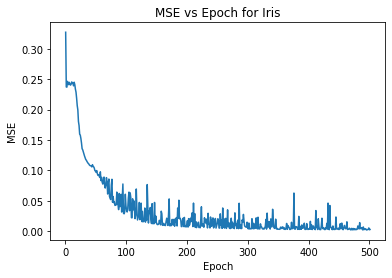

In [16]:
#plotting MSEs
plt.plot(np.arange(1,len(Mi.MSEs)+1,1),Mi.MSEs)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("MSE vs Epoch for Iris")
plt.show()

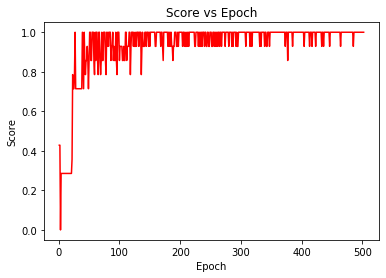

In [17]:
#plotting scores
plt.plot(np.arange(1,len(Mi.vScores)+1,1),Mi.vScores,'r')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Score vs Epoch")
plt.show()



## 3. (10%) Working with the Vowel Dataset - Learning Rate

Load the Vowel Dataset [Vowel Dataset](https://byu.instructure.com/courses/14142/files?preview=4537354)

- Use one layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use random 80/20 splits of the data for the training/test set.
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Try some different learning rates (LR). Note that each LR will probably require a different number of epochs to learn. 

- For each LR you test, plot their validation's set MSE over Epochs on the same graph. Graph 4-5 different LRs and make them different enough to see a difference between them.

In general, whenever you are testing a parameter such as LR, # of hidden nodes, etc., test values until no more improvement is found. For example, if 20 hidden nodes did better than 10, you would not stop at 20, but would try 40, etc., until you no longer get improvement.

If you would like you may average the results of multiple initial conditions (e.g. 3) per LR, and that obviously would give more accurate results.

<img src=https://raw.githubusercontent.com/cs472ta/CS472/master/images/backpropagation/backprop_val_set_MSE_vs_epochs.png width=500 height=500  align="left">

In [18]:
data = arff.loadarff("vowel.arff")
df = pd.DataFrame(data[0])
df

,Train or Test,Speaker Number,Sex,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Class
0,b'Train',b'Andrew',b'Male',-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814,b'hid'
1,b'Train',b'Andrew',b'Male',-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488,b'hId'
2,b'Train',b'Andrew',b'Male',-2.120,0.894,-1.576,0.147,-0.707,1.559,-0.579,0.676,-0.809,-0.049,b'hEd'
3,b'Train',b'Andrew',b'Male',-2.287,1.809,-1.498,1.012,-1.053,1.060,-0.567,0.235,-0.091,-0.795,b'hAd'
4,b'Train',b'Andrew',b'Male',-2.598,1.938,-0.846,1.062,-1.633,0.764,0.394,-0.150,0.277,-0.396,b'hYd'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,b'Test',b'Wendy',b'Female',-3.239,3.083,-1.427,-0.202,-0.282,1.421,0.576,0.068,-0.914,0.147,b'hOd'
986,b'Test',b'Wendy',b'Female',-3.753,3.605,-0.899,-0.747,-0.401,1.765,0.620,0.754,-0.835,-0.301,b'hod'
987,b'Test',b'Wendy',b'Female',-3.980,2.459,0.068,0.023,0.237,1.029,-0.189,0.521,-0.773,-0.500,b'hUd'
988,b'Test',b'Wendy',b'Female',-4.264,2.925,0.065,0.794,0.323,0.515,-1.282,-0.140,-0.863,-0.390,b'hud'


In [19]:
classes = dict()
for i, Class in enumerate(set(df['Class'])):
    classes[Class] = i

In [20]:
classes

{b'hod': 0,
 b'hUd': 1,
 b'hYd': 2,
 b'hId': 3,
 b'hud': 4,
 b'hEd': 5,
 b'had': 6,
 b'hOd': 7,
 b'hed': 8,
 b'hid': 9,
 b'hAd': 10}

In [21]:
targets = np.zeros((990,len(classes)))
for i in range(990):
    #index is 
    index = classes[df['Class'][i]]
    targets[i][index] = 1
targets

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [22]:
def DecodeS(sex):
    """decode sex as 0 if Male, 1 if Female"""
    if sex == b'Male': return 0
    else: return 1

#reading inputs
Vowels = []
for i in range(990):
    xi = [DecodeS(df['Sex'][i]),df['Feature 0'][i],df['Feature 1'][i],df['Feature 2'][i],df['Feature 3'][i],df['Feature 4'][i],df['Feature 5'][i],
         df['Feature 6'][i],df['Feature 7'][i],df['Feature 8'][i],df['Feature 9'][i]]
    Vowels.append(xi)
Vowels = np.array(Vowels)

In [23]:
#shuffling data for 80/20 split
inds = np.arange(0,990,1)
np.random.shuffle(inds)
Vowels = Vowels[inds]
targets = targets[inds]

#setting apart training and testing
VowelsTrain = Vowels[:792]
VowelsTest  = Vowels[792:]
targetsTrain= targets[:792]
targetsTest = targets[792:]

In [24]:
#make an initial MLP with lr = 0.1 and HLW twice the number of inputs
vM = MLP(lr=0.1,hidden_layer_widths=[22],determ=False,validate=True)

In [25]:
#fitting to train data
vM.fit(VowelsTrain,targetsTrain,Cap=100,threshold=0.0015)

next fit starting
MSE converging, breaking



MLP(determ=False, hidden_layer_widths=[22], validate=True)

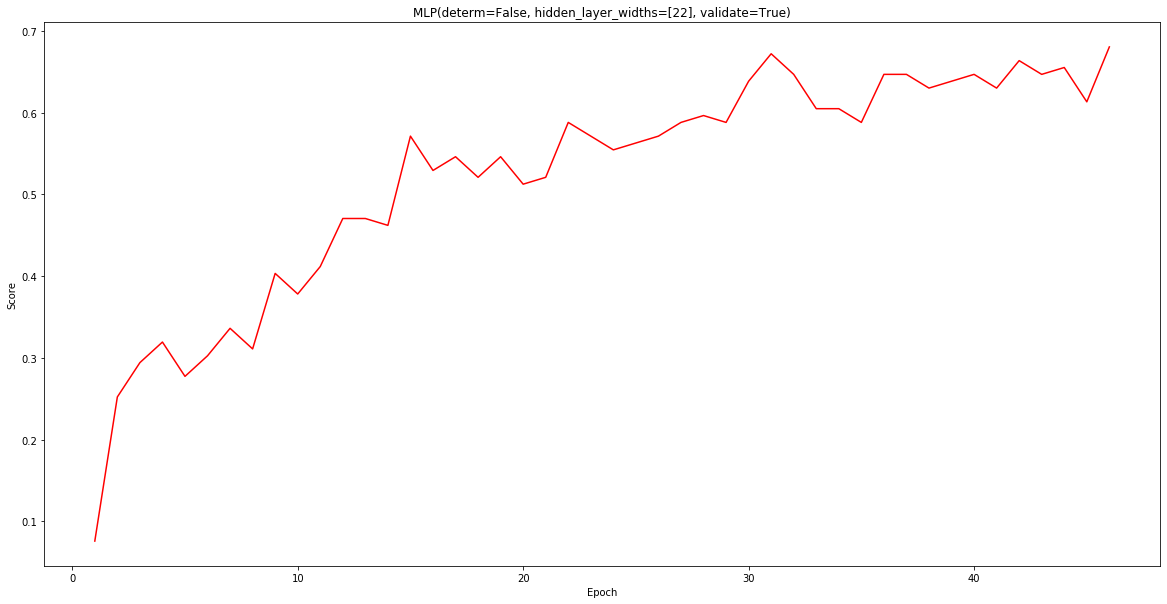

In [26]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(np.arange(1,len(vM.vScores)+1,1),vM.vScores,'r')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title(str(vM))
plt.show()

In [27]:
#general accuracy of MLP on test set
vM.score(VowelsTest,targetsTest)

0.6717171717171717

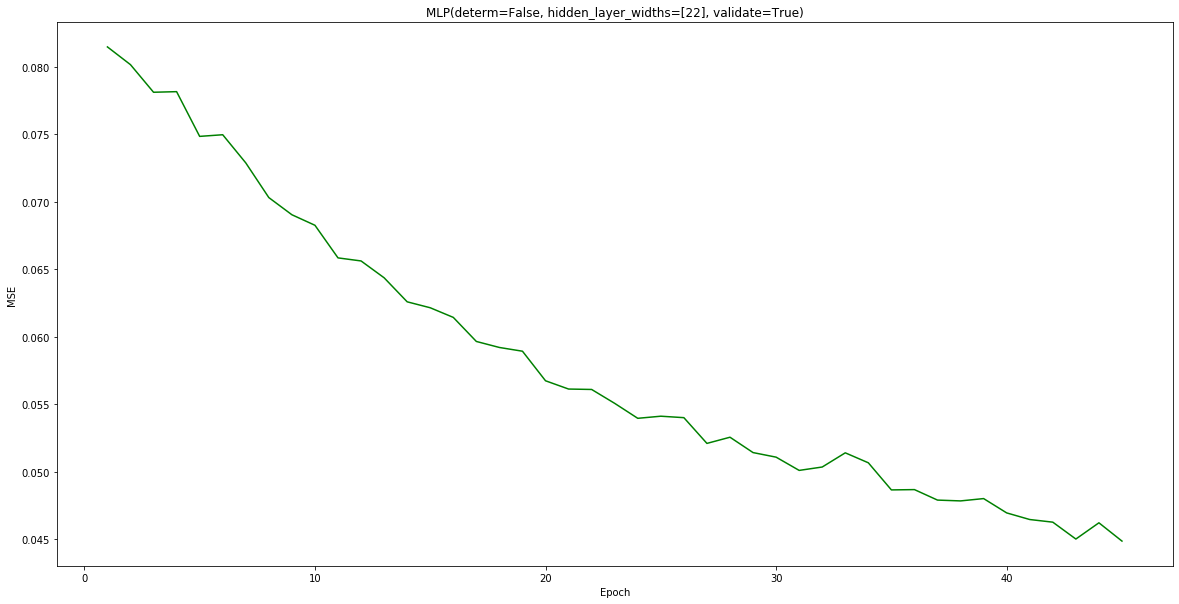

In [29]:
plt.plot(np.arange(1,len(vM.MSEs)+1,1),vM.MSEs,'g')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title(str(vM))
plt.show()

In [30]:
#Creating nodes of different learning rates
vM0 = MLP(lr=0.01,hidden_layer_widths=[22],determ=False,validate=True)
vM1 = MLP(lr=0.32,hidden_layer_widths=[22],determ=False,validate=True)
vM2 = MLP(lr=0.63,hidden_layer_widths=[22],determ=False,validate=True)
vM3 = MLP(lr=0.94,hidden_layer_widths=[22],determ=False,validate=True)
vM4 = MLP(lr=1.25,hidden_layer_widths=[22],determ=False,validate=True)

In [31]:
# Train on each dataset
for VM in [vM0,vM1,vM2,vM3,vM4]:
    VM.fit(VowelsTrain,targetsTrain,Cap=80,threshold=0.005)

next fit starting
MSE converging, breaking

next fit starting
MSE converging, breaking

next fit starting
MSE converging, breaking

next fit starting
cap reached, breaking

next fit starting
MSE worsening, breaking



In [32]:
#score for lr=0.1
vM.score(VowelsTest,targetsTest)

0.6717171717171717

In [33]:
#score for lr=0.01
vM0.score(VowelsTest,targetsTest)

0.21717171717171718

In [34]:
#score for lr=0.32
vM1.score(VowelsTest,targetsTest)

0.6111111111111112

In [35]:
#score for lr=0.63
vM2.score(VowelsTest,targetsTest)

0.7575757575757576

In [36]:
#score for lr=0.94
vM3.score(VowelsTest,targetsTest)

0.7424242424242424

In [37]:
#score for lr=1.25
vM4.score(VowelsTest,targetsTest)

#NOTE: Even though this one has a greater accuracy on the test set, its MSE is greater on the validation (see below),
#its MSE is more unstable, and it takes longer to train

0.7272727272727273

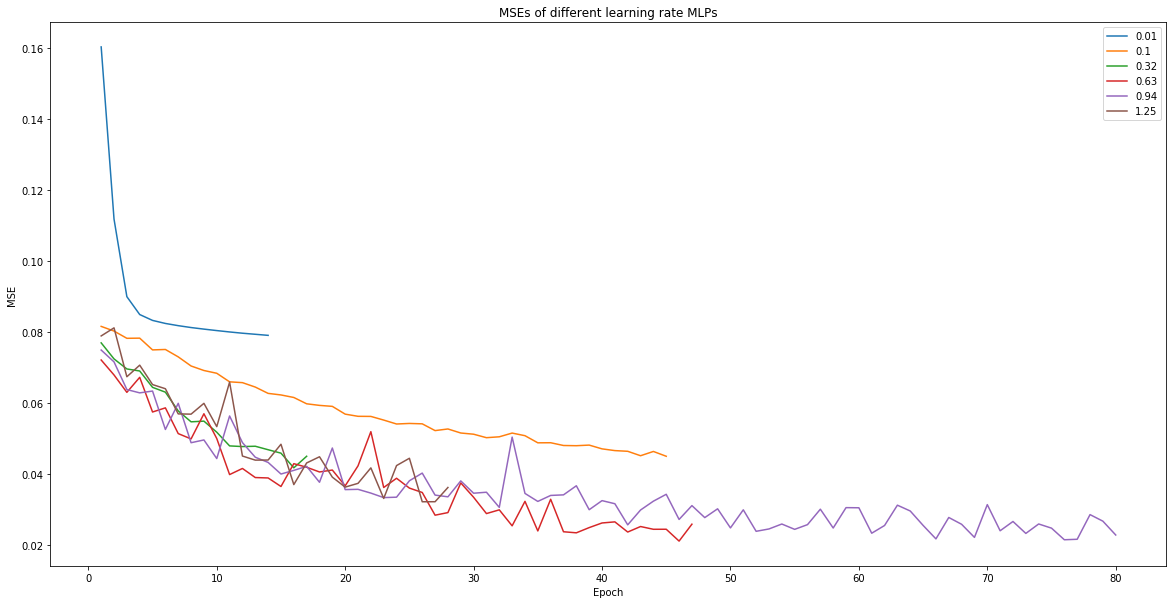

In [38]:
#plotting mse value for each MLP
for VM in [vM0,vM,vM1,vM2,vM3,vM4]:
    plt.plot(np.arange(1,len(VM.MSEs)+1,1),VM.MSEs,label=str(VM.lr))
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("MSEs of different learning rate MLPs")
plt.show()

## 3.1 (5%) Working with the Vowel Dataset - Intuition
- Discuss the effect of varying learning rates. 
- Discuss why the vowel data set might be more difficult than Iris
    - Report both datasets' baseline accuracies and best **test** set accuracies. 
- Consider which of the vowel dataset's given input features you should actually use (Train/test, speaker, gender, ect) and discuss why you chose the ones you did.

Typical backpropagation accuracies for the Vowel data set are above 75%.



In [39]:
#creating two different MLPs to calc baseline accuracies of both
baseIris  = MLP(lr=0.1,hidden_layer_widths=[8],determ=False,validate=True)
baseVowel = MLP(lr=0.1,hidden_layer_widths=[22],determ=False,validate=True)

#calling fit just to make the nodes, but not actually fitting
baseIris.fit(FlowersTest,FtargetsTest,dontFit=True)
baseVowel.fit(VowelsTest,targetsTest,dontFit=True)

#getting baseline accuracies
score1 = baseIris.score(FlowersTest,FtargetsTest)
score2 = baseVowel.score(VowelsTest,targetsTest)

#printing results
print('baseline accuracy of iris =',score1)
print('baseline accuracy of vowels =',score2)

next fit starting
next fit starting
baseline accuracy of iris = 0.6666666666666666
baseline accuracy of vowels = 0.04040404040404041


Varying the learning rate led to the quickest convergence with the greatest accuracy being found at lr=0.63. Other lower learning rates converged faster but with lower accuracy. Higher learning rates took much longer to converge and still were not as consistently accurate as 0.64.

The vowel set may be more difficult to deal with than Iris because it has a greater number of inputs (990 in total), so there are many more calculations to be done, and there are a greater number of features, magnifying the strain from the extra inputs.

I chose not to include the Train/Test class nor the Speaker Numbers (their names) because the former is meaningless to our data set, so using it to predict anything is pointless, and the speaker names were not used because all the data they would provide is completely encompassed by the other features. Being named "Andrew" does not make anyone unique.

## 3.2 (10%) Working with the Vowel Dataset - Hidden Layer Nodes

Using the best LR you discovered, experiment with different numbers of hidden nodes.

- Start with 1 hidden node, then 2, and then double them for each test until you get no more improvement in accuracy. 
- For each number of hidden nodes find the best validation set solution (in terms of validation set MSE).  
- Create one graph with MSE for the training set and validation set on the y-axis and # of hidden nodes on the x-axis.
- Report the final test set accuracy for every # of hidden nodes you experimented on

In [40]:
#best lr for me was 0.63
#make lists to hold scores
group_mses = []
scores = [0]

k = 0
while True:
    #print log_2 of the hidden layer width
    print(k)
    
    #create MLP object with best lr, with a power of 2 hidden nodes; fit
    vm = MLP(lr=0.63,hidden_layer_widths=[2**k],determ=False,validate=True)
    vm.fit(VowelsTrain,targetsTrain,threshold=0.005)
    
    #record scores
    group_mses.append(vm.MSEs)
    score = vm.score(VowelsTest,targetsTest)
    scores.append(score)
    #print score and previous score
    print('score =',score,'scores[k] =',scores[k])
    
    #if score decreases, break
    if score < scores[k]: break

    #inc k
    k += 1

0
next fit starting
MSE converging, breaking

score = 0.1717171717171717 scores[k] = 0
1
next fit starting
MSE converging, breaking

score = 0.14646464646464646 scores[k] = 0.1717171717171717


In [41]:
#getting final MSE values for each for plotting purposes
to_plot_mse = [group[-1] for group in group_mses]
to_plot_mse

[0.07383273184619846, 0.07697476342249439]

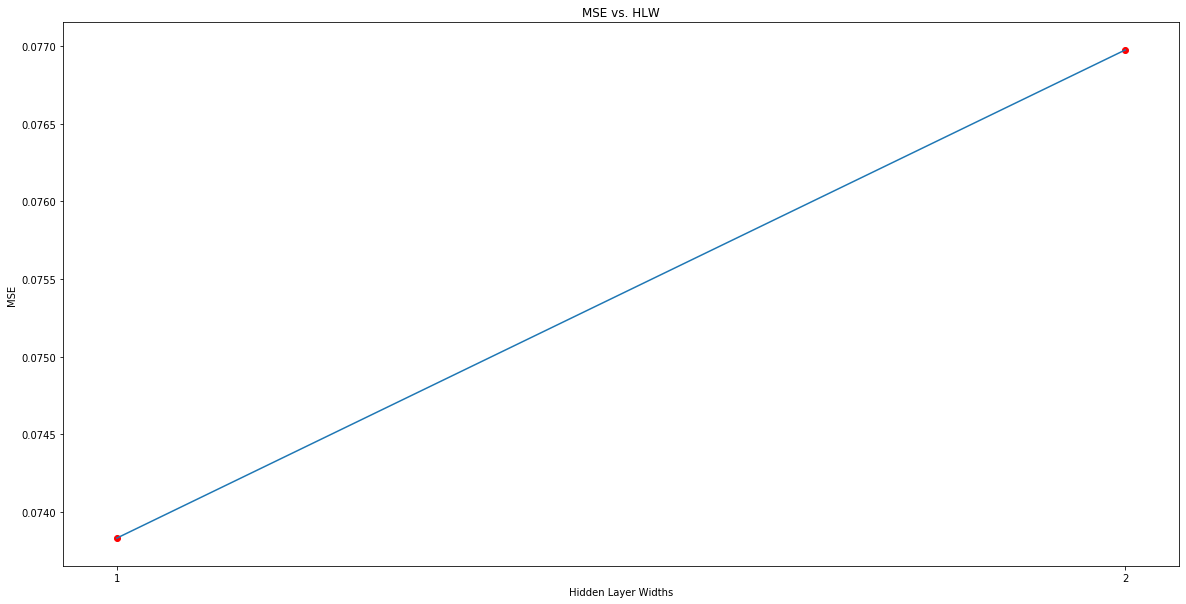

In [44]:
#plotting MSE vs HLW
HLWs = [1,2]
plt.plot(HLWs,to_plot_mse)
plt.scatter(HLWs,to_plot_mse,color='r')
plt.xticks(HLWs,HLWs)
plt.xlabel("Hidden Layer Widths")
plt.ylabel("MSE")
plt.title("MSE vs. HLW")
plt.show()

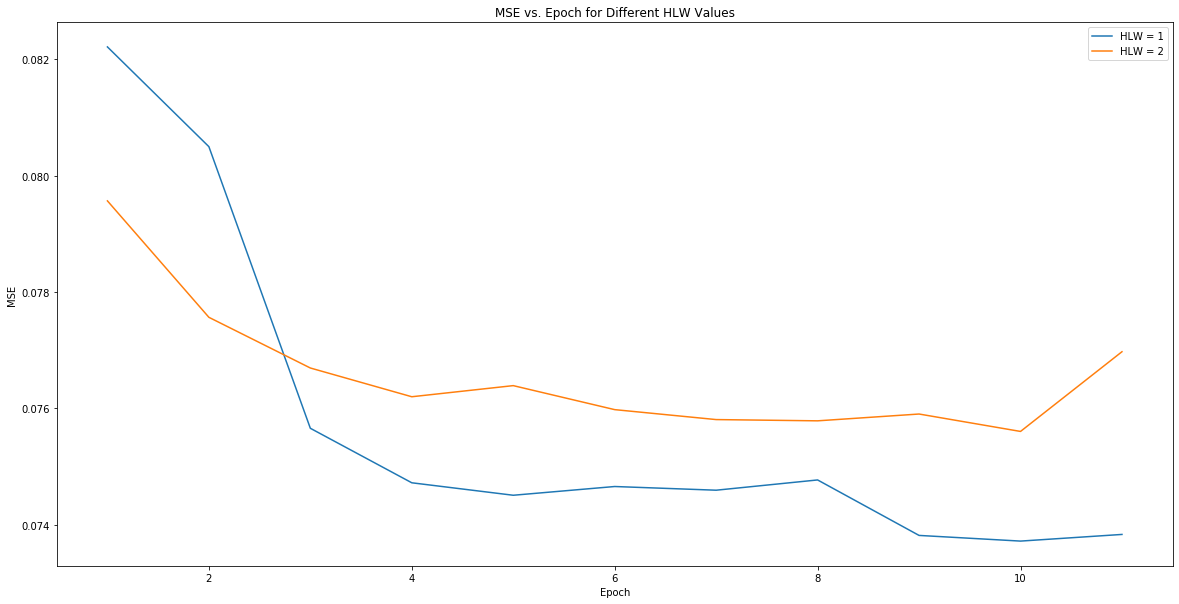

In [45]:
#plotting MSE vs Epochs for my own... enjoyment?
for i,group in enumerate(group_mses):
    plt.plot( np.arange(1, len(group)+1), group, label = 'HLW = '+str(2**i)    )
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("MSE vs. Epoch for Different HLW Values")
plt.show()

The best accuracy for the number of hidden nodes (sans bias) is with 64 nodes. It allows for the most amount of accurate information processing without overfitting than 128 nodes, and is simply vastly more accurate than with fewer nodes.

## 3.3 (10%) Working with the Vowel Dataset - Momentum

Try some different momentum terms using the best number of hidden nodes and LR from your earlier experiments.

- Create a graph similar to step 3.2, but with momentum on the x-axis and number of epochs until validation set convergence on the y-axis.
- For each momentum term, print the test set accuracy. 
- You are trying to see how much momentum speeds up learning and how it affects accuracy.

In [46]:
#best lr for me was 0.63 and best HLW was 64
#make lists to hold scores
Mom_mses = []
Mom_scores = [0]
Mom_epochs = []

for k in range(1,6):
    #print k
    print(k)
    
    #make MLP object with best lr and hidden layer width; make momentum k/4
    vm = MLP(lr=0.63,momentum=(0.175*k),hidden_layer_widths=[64],determ=False,validate=True)
    vm.fit(VowelsTrain,targetsTrain,threshold=0.01)
    
    #record scores and itrs
    Mom_epochs.append(vm.itrs)
    Mom_mses.append(vm.MSEs)
    Mom_score = vm.score(VowelsTest,targetsTest)
    Mom_scores.append(Mom_score)
    
    #print score
    print('score =',Mom_score,'scores[k-1] =',Mom_scores[k-1])

1
next fit starting
MSE converging, breaking

score = 0.6868686868686869 scores[k-1] = 0
2
next fit starting
MSE converging, breaking

score = 0.5454545454545454 scores[k-1] = 0.6868686868686869
3
next fit starting
MSE worsening, breaking

score = 0.5808080808080808 scores[k-1] = 0.5454545454545454
4
next fit starting
MSE converging, breaking

score = 0.12626262626262627 scores[k-1] = 0.5808080808080808
5
next fit starting
MSE converging, breaking

score = 0.050505050505050504 scores[k-1] = 0.12626262626262627


In [47]:
#running it for momentum 0 because I didn't put it in up there and I don't want to rerun the whole thing
vm = MLP(lr=0.63,momentum=0,hidden_layer_widths=[64],determ=False,validate=True)
vm.fit(VowelsTrain,targetsTrain,threshold=0.01)

next fit starting
MSE converging, breaking



MLP(determ=False, hidden_layer_widths=[64], lr=0.63, validate=True)

In [48]:
#showing the score for this fit
vm.score(VowelsTest,targetsTest)

0.6666666666666666

In [49]:
#inserting 0 momentum's epoch number
Mom_epochs.insert(0,vm.itrs)

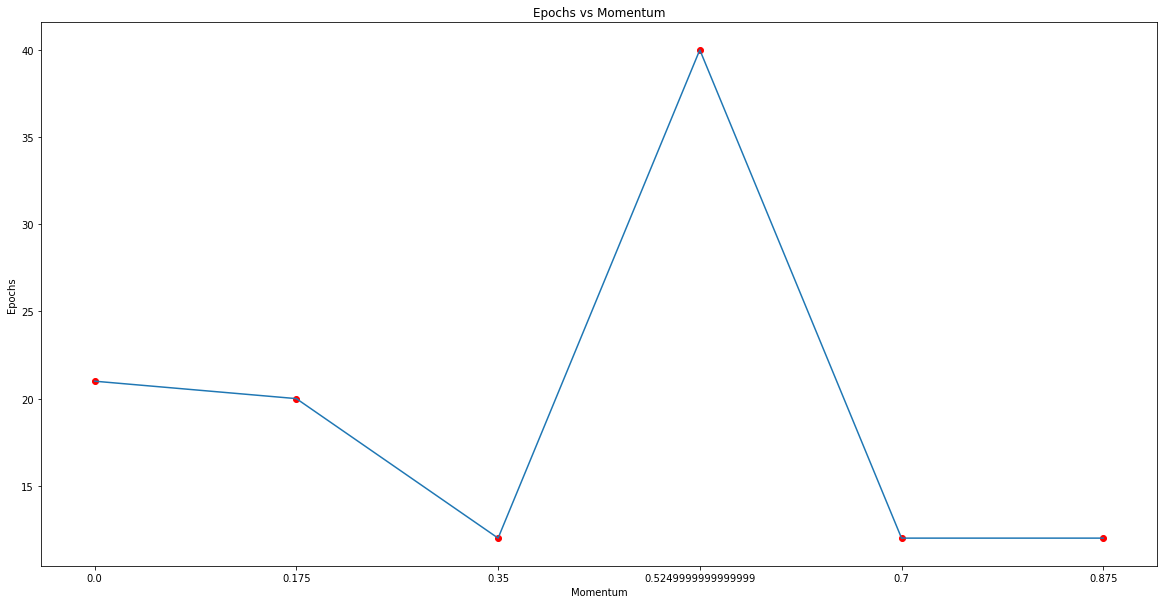

In [50]:
#plotting the epochs vs momentum
plt.plot(np.arange(0,1.0,0.175),Mom_epochs)
plt.scatter(np.arange(0,1.0,0.175),Mom_epochs,color='r')
plt.xlabel("Momentum")
plt.ylabel("Epochs")
plt.title("Epochs vs Momentum")
plt.xticks(np.arange(0,1.0,0.175),np.arange(0,1.0,0.175))
plt.show()

The momentum did not consistently make the number of epochs needed to converge smaller. Given how I coded it, the minimum it could be is 12, which is the value of the horizontal portions of this graph. It is likely that for momentum 0.35, the minimum that was being targeted was overshot a few times; its number of epochs is twice that of the others. However, the momentum does seem to make the convergence quicker for all the others. However, all the scores are lower than when momentum is 0, and this is likely due to overshooting the true minimums.

## 4.1 (10%) Use the scikit-learn (SK) version of the MLP classifier on the Iris and Vowel data sets.  

You do not need to go through all the steps above, nor graph results. Compare results (accuracy and learning speed) between your version and theirs for some selection of hyper-parameters. Try different hyper-parameters and comment on their effect.

At a minimum, try

- number of hidden nodes and layers
- different activation functions
- learning rate
- regularization and parameters
- momentum (and try nesterov)
- early stopping

In [51]:
# Load sklearn MLPClassifier
ScM1 = MLPClassifier(hidden_layer_sizes=(64),activation='logistic',learning_rate_init=0.63)
ScM2 = MLPClassifier(hidden_layer_sizes=(64),activation='logistic',learning_rate_init=0.1)
ScM3 = MLPClassifier(hidden_layer_sizes=(64),activation='relu',learning_rate_init=0.1)
ScM4 = MLPClassifier(hidden_layer_sizes=(64),activation='relu',learning_rate_init=0.1,nesterovs_momentum=False)
ScM5 = MLPClassifier(hidden_layer_sizes=(22),activation='relu',learning_rate_init=0.1)

# Train on vowels
ScM1.fit(VowelsTrain,targetsTrain)
ScM2.fit(VowelsTrain,targetsTrain)
ScM3.fit(VowelsTrain,targetsTrain)
ScM4.fit(VowelsTrain,targetsTrain)
ScM5.fit(VowelsTrain,targetsTrain)

MLPClassifier(hidden_layer_sizes=22, learning_rate_init=0.1)

In [52]:
#scoring each
print("ScM1  score =",ScM1.score(VowelsTest,targetsTest))
print("ScM2  score =",ScM2.score(VowelsTest,targetsTest))
print("ScM3  score =",ScM3.score(VowelsTest,targetsTest))
print("ScM4  score =",ScM4.score(VowelsTest,targetsTest))
print("ScM5  score =",ScM5.score(VowelsTest,targetsTest))

ScM1  score = 0.6060606060606061
ScM2  score = 0.8535353535353535
ScM3  score = 0.8333333333333334
ScM4  score = 0.7777777777777778
ScM5  score = 0.48484848484848486


In [53]:
# Load sklearn MLPClassifier
ScMi1 = MLPClassifier(hidden_layer_sizes=(4),activation='logistic',learning_rate_init=0.3)
ScMi2 = MLPClassifier(hidden_layer_sizes=(8),activation='logistic',learning_rate_init=0.1)
ScMi3 = MLPClassifier(hidden_layer_sizes=(8),activation='relu',learning_rate_init=0.1)
ScMi4 = MLPClassifier(hidden_layer_sizes=(8),activation='relu',learning_rate_init=0.1,nesterovs_momentum=False)
ScMi5 = MLPClassifier(hidden_layer_sizes=(8),activation='relu',learning_rate_init=0.1)
ScMi6 = MLPClassifier(hidden_layer_sizes=(16),activation='logistic',learning_rate_init=0.1)

# Train on flowers
ScMi1.fit(FlowersTrain,FtargetsTrain)
ScMi2.fit(FlowersTrain,FtargetsTrain)
ScMi3.fit(FlowersTrain,FtargetsTrain)
ScMi4.fit(FlowersTrain,FtargetsTrain)
ScMi5.fit(FlowersTrain,FtargetsTrain)
ScMi6.fit(FlowersTrain,FtargetsTrain)

MLPClassifier(activation='logistic', hidden_layer_sizes=16,
              learning_rate_init=0.1)

In [54]:
#scoring each
print("ScMi1  score =",ScMi1.score(FlowersTest,FtargetsTest))
print("ScMi2  score =",ScMi2.score(FlowersTest,FtargetsTest))
print("ScMi3  score =",ScMi3.score(FlowersTest,FtargetsTest))
print("ScMi4  score =",ScMi4.score(FlowersTest,FtargetsTest))
print("ScMi5  score =",ScMi5.score(FlowersTest,FtargetsTest))
print("ScMi6  score =",ScMi6.score(FlowersTest,FtargetsTest))

ScMi1  score = 1.0
ScMi2  score = 0.9833333333333333
ScMi3  score = 0.9833333333333333
ScMi4  score = 1.0
ScMi5  score = 0.9833333333333333
ScMi6  score = 0.9833333333333333


Well, it is so much faster, which I'm jealous of. The scoring on the vowel data set definitely shows more variation depending on the hyperparameters. For my tests of it, having 64 nodes, lr=0.1, logistic, and nesterov momentum, the best score was attained. For Iris, since there is less variation in the data, it is more difficult to see how the hyperparameters affect the scoring. However it is clear that halving the number of nodes cripples accuracy regardless of learning rate (it's at its baseline accuracy), and all the other hyperparameters did not otherwise make any change on the accuracy. 

## 4.2 (5%) Using the Iris Dataset automatically adjust hyper-parameters using your choice of grid/random search
- Use a grid or random search approach across a reasonable subset of hyper-parameters from the above 
- Report your best accuracy and hyper-parameters. 

In [55]:
# Load sklearn MLP and vary learning rates
scores = []
for i in range(1,100):
    ScM = MLPClassifier(hidden_layer_sizes=(8),activation='logistic',learning_rate_init=i/100.)
    ScM.fit(FlowersTrain,FtargetsTrain)
    scores.append(ScM.score(FlowersTest,FtargetsTest))

In [56]:
#reporting best learning rate
print("The best score was found with a learning rate of",np.argmax(scores)+1,'/ 100')

The best score was found with a learning rate of 1 / 100


In [57]:
# Load sklearn MLP with 1/50 lr and now vary HLW
scores2 = []
for i in range(1,100):
    ScM = MLPClassifier(hidden_layer_sizes=(i),activation='logistic',learning_rate_init=1/50.)
    ScM.fit(FlowersTrain,FtargetsTrain)
    scores2.append(ScM.score(FlowersTest,FtargetsTest))

In [58]:
#reporting best HLW
print("The best score was found with a hidden layer size of",np.argmax(scores2)+1)

The best score was found with a hidden layer size of 4


It appears that when using logistic activation and the other defaults, the best scoring for the iris data set comes from a hidden layer size of 7 and learning rate of 0.02